In [ ]:
%%HTML
<style> code {background-color : pink !important;} </style>

Advanced Land Line Detection
===


In [92]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)

def getimageobjpoints(x,y):
    objp = np.zeros((x*y,3), np.float32)
    objp[:,:2] = np.mgrid[0:x, 0:y].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/cal*.jpg')
 
    i = 0 
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (x,y), None)
    # If found, add object points, image points
        if ret == True:
            i = i + 1 
            objpoints.append(objp)
            imgpoints.append(corners)

        # Draw and display the corners
            cv2.drawChessboardCorners(img, (x,y), corners, ret)
            write_name = 'corners_found'+str(idx)+'.jpg'
            cv2.imwrite('output_images/'+ write_name, img)
            #cv2.imshow('img'+str(i), img)
            #cv2.waitKey(500)
            #plt.imshow(img)
            #plt.show()

getimageobjpoints(9,5)
getimageobjpoints(9,6)
getimageobjpoints(8,5)
getimageobjpoints(8,6)
        
#cv2.destroyAllWindows()

### Save the camera calibration result for later use (we won't worry about rvecs / tvecs)

In [93]:
import pickle

dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration/wide_dist_pickle.p", "wb" ) )

In [124]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

def display_img(img,binary_output,title='Output Image',cmaptype='gray'):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=50)
    if cmaptype == None:
        ax2.imshow(binary_output)
    else:
        ax2.imshow(binary_output,cmap=cmaptype)
    ax2.set_title(title, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


### If the above cell ran sucessfully, you should now have `objpoints` and `imgpoints` needed for camera calibration.  Run the cell below to calibrate, calculate distortion coefficients, and test undistortion on an image!

In [123]:
%matplotlib inline
import ntpath


print("Loaded camera calibration results")



def undistortimg(fname,mtx,dist,output_dir,visualize=False):
    # Test undistortion on an image
    print("Undistorting " + fname)
    img = cv2.imread(fname)

    # Do camera calibration given object points and image points
    #ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,(img.shape[0],img.shape[1]),None,None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite(output_dir+'/undist_'+path_leaf(fname),dst)

    # Visualize undistortion
    if(visualize):
        display_img(img,dst,title='Undistorted Image')

def process_distorted_images(test_images):
    for idx,fname in enumerate(test_images):
        undistortimg(fname,mtx,dist,'output_images',visualize=False)

process_distorted_images(glob.glob('camera_cal/cal*.jpg'))
process_distorted_images(glob.glob('test_images/*.jpg'))

plt.close()


Loaded camera calibration results
Undistorting camera_cal/calibration1.jpg
Undistorting camera_cal/calibration10.jpg
Undistorting camera_cal/calibration11.jpg
Undistorting camera_cal/calibration12.jpg
Undistorting camera_cal/calibration13.jpg
Undistorting camera_cal/calibration14.jpg
Undistorting camera_cal/calibration15.jpg
Undistorting camera_cal/calibration16.jpg
Undistorting camera_cal/calibration17.jpg
Undistorting camera_cal/calibration18.jpg
Undistorting camera_cal/calibration19.jpg
Undistorting camera_cal/calibration2.jpg
Undistorting camera_cal/calibration20.jpg
Undistorting camera_cal/calibration3.jpg
Undistorting camera_cal/calibration4.jpg
Undistorting camera_cal/calibration5.jpg
Undistorting camera_cal/calibration6.jpg
Undistorting camera_cal/calibration7.jpg
Undistorting camera_cal/calibration8.jpg
Undistorting camera_cal/calibration9.jpg
Undistorting test_images/solidWhiteRight.jpg
Undistorting test_images/solidYellowLeft.jpg
Undistorting test_images/test1.jpg
Undistorti

<function combine_binary at 0x11e4fba60>


TypeError: Image data can not convert to float

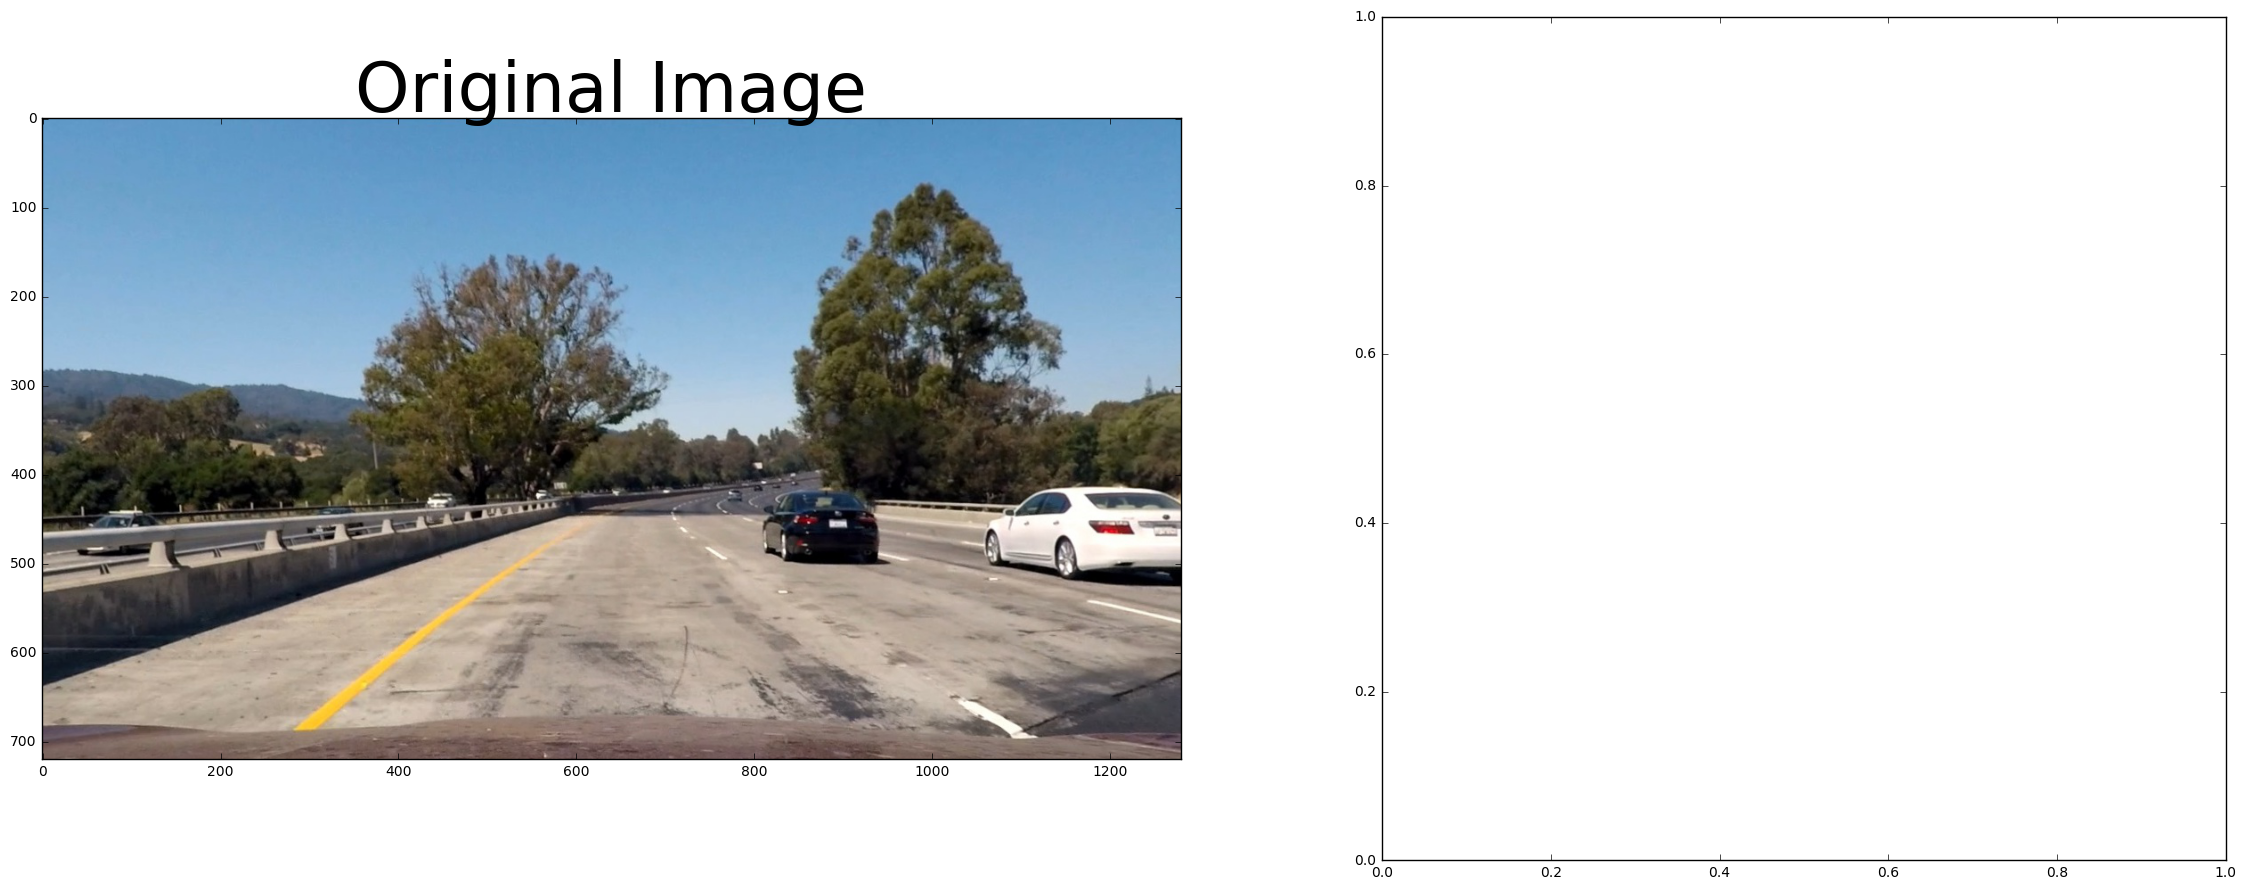

In [143]:
import matplotlib.image as mpimg

#Convert to grayscale and apply sobel operator

def mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 130)):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag > mag_thresh[0]) & (gradmag < mag_thresh[1])] = 1
    # Return the binary image
    return binary_output


def abs_sobel_thresh(img, orient='x', thresh=(20,100)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return the result
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def combine(gradx,grady,mag_binary,dir_binary):
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

def combine_binary(sxbinary,s_binary):
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combine_binary

def combine_color_binary(sxbinary,s_binary):
    return np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

images = glob.glob('output_images/undist_test*.jpg')


def pipeline(img, s_thresh=(150, 255), sx_thresh=(20, 150)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    combined_binary = np.zeros_like(sxbinary).astype(np.float)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return color_binary,combine_binary

for idx,fname in enumerate(images):
    img = cv2.imread(fname)
    
    color_img,combine_binary_img = pipeline(img)
    print(combine_binary_img)
    display_img(img,color_img)
    
